In [1]:
import pyboard
import time
import json
import numpy as np
from pylab import *
from tqdm import tqdm

%matplotlib inline

Define some helpers

In [2]:
def save(fname):
    """ Save latest spectral image including header as a numpy file (for now)
    """
    global header, SpectImg, wavelengths_nm
    with open(fname, 'wb') as f:
        np.save(f, header)
        np.save(f, SpectImg)
        np.save(f, wavelengths_nm)
    
def nan2zero(data):
    """ Replace NaNs and negative values by zeros
    """
    return [val if val>0 else 0 for val in data]

### Connect to scanner (microcontroller)

Define a function that runs the code contained in a list of strings on the ESP32. By default, it does not print any text coming from the microcontroller into the history. The function returns the output of the last command as a string.

Generate a pyboard object on the COM port connected to the ESP32 (here `COM3`) and enter REPL mode; the MicroPython "shell" is now ready to receive commands

In [3]:
def run_on_board(code, wait_s=0, no_print=False):
    for ln in code:
        res = pb.exec(ln)
        if len(res) > 0 and not no_print:
            res = res[:-2].decode()
            print(res)
    if wait_s > 0:
        time.sleep(wait_s)        
    return res        

pb = None
try:
    pb = pyboard.Pyboard("COM3")
    pb.enter_raw_repl()  
except pyboard.PyboardError as e:
    print(e)     

### Create a scanner object ...

... on the microcontroller.

In [4]:
script = [
    'from scanner import Scanner',
    'sc = Scanner(verbose=False)',
]
tmp = run_on_board(script, wait_s=0.4, no_print=False)

c,_|Initializing ...
Servo at pin 27 (50 Hz) ready.
Servo at pin 33 (50 Hz) ready.
c,_|Servo manager ready
c,_|Spectrometer ready


### Scan 

First prepare a scan and retrieve important information fro the ESP32 (`header`) ...

In [5]:
dxy = (63,63)       # Dimension of the image
dStep = 1           # Step size in [°]
tInt_s = 0.005      # Integration time in seconds
fname = ""          # File name, keep empty if only temporary

header = {}
wavelengths_nm = None

s = "({0},{1}), ({2},{3}), {4}".format(dxy[0], dxy[1], dStep, dStep, tInt_s)
tmp = run_on_board(['sc.setupScan("", {0})'.format(s)], no_print=True)
tmpList = tmp.decode().split("\r\n")
for ln in tmpList:
    if len(ln.split("|")) > 1:
        s = ln.split("|")[1].replace("\'", "\"")
        if ln[0] == "c":
            # This is a comment, ignore
            pass
        elif ln[0] == "w":
            # Extract wavelengths
            wavelengths_nm = np.array(json.loads(s)["wavelength_nm"])
        elif ln[0] == "h":    
            # Extract header information
            header.update(json.loads(s))
        else:    
            print("-")

print(header)     

{'file_version': 1, 'date_yyyymmdd': [2000, 1, 1], 'time_hhmmss': [0, 0, 12], 'step_xy_deg': [1, 1], 'n_spect': 288, 'size_xy': [63, 63], 't_int_s': 0.005}


... and then perform scan

In [ ]:
dx, dy = header["size_xy"]
sx, sy = header["step_xy_deg"]
nPix = dx *dy
SpectImg = np.zeros((dx,dy, header["n_spect"]))

for iPix in tqdm(range(nPix)):
    tmp = run_on_board(["sc.scanNext()"], no_print=True)
    ln = tmp.decode().split("\r\n")[0].split("|")
    if len(ln) > 1:
        s = ln[1].replace("\'", "\"")
        d = json.loads(s)
        x, y = d["xy"]
        x = int(x /sx +dx//2)
        y = int(y /sy +dy//2)
        SpectImg[x][y] = d["spect_au"]
        #print(x, y)

 70%|██████████████████████████████████████████████████████▊                       | 2789/3969 [13:12<05:26,  3.62it/s]

### Process and display data

First, generate a black/white image of the scene

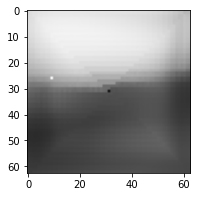

In [7]:
dx, dy, n = SpectImg.shape
imgMono = np.zeros((dx, dy, 3))
img = np.trapz(SpectImg)
img /= img.max()
for iCh in range(3):
    imgMono[:,:,iCh] = img
    
fig, (ax1) = plt.subplots(1, 1, figsize=(9,3))
im1 = ax1.imshow(imgMono)    

Make a normalized copy of the spectral image

In [8]:
SpectImgN = np.copy(SpectImg)
SpectImgN -= SpectImg.min()
SpectImgN /= SpectImg.max()

Load human opsin curves and make interpolated versions on the x-scale of the spectral images

Text(0.5, 0, '[nm]')

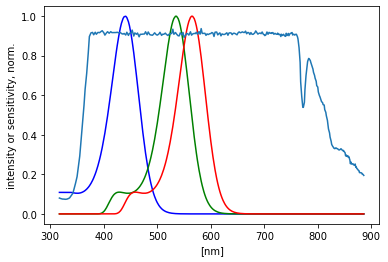

In [11]:
opsin_nm = np.load("opsins/wavelengths_nm.npz")["nm"]
tempData = np.load("opsins/human_SML.npz")

opsin_hSI = np.interp(wavelengths_nm, opsin_nm, nan2zero(tempData["s"]))
opsin_hMI = np.interp(wavelengths_nm, opsin_nm, nan2zero(tempData["m"]))
opsin_hLI = np.interp(wavelengths_nm, opsin_nm, nan2zero(tempData["l"]))

plot(wavelengths_nm, opsin_hSI, "b")
plot(wavelengths_nm, opsin_hMI, "g")
plot(wavelengths_nm, opsin_hLI, "r")
plot(wavelengths_nm, SpectImgN[0,0])
ylabel("intensity or sensitivity, norm.")
xlabel("[nm]")

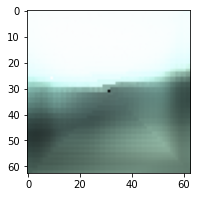

In [12]:
dx, dy, n = SpectImg.shape
imgRGB = np.zeros((dx, dy, 3))

s = opsin_hSI *SpectImgN
img_s = np.trapz(s)
imgRGB[:,:,0] = img_s /img_s.max()
m = opsin_hMI *SpectImgN
img_m = np.trapz(m)
imgRGB[:,:,1] = img_m /img_m.max()
l = opsin_hLI *SpectImgN
img_l = np.trapz(l)
imgRGB[:,:,2] = img_l /img_l.max()

#img /= img.max()
fig, (ax1) = plt.subplots(1, 1, figsize=(9,3))
im1 = ax1.imshow(imgRGB)    

In [ ]:
import h5py
path = "BadenSchubert2013_SpectraPics.h5"
with h5py.File(path, 'r') as f:
    wavelengths  = f["opsin_spectra"]["wavelengths"][:]
    mouse_scone  = f["opsin_spectra"]["mouse_Spect360"][:]
    mouse_mcone  = f["opsin_spectra"]["mouse_Spect511"][:]
    human_scone  = f["opsin_spectra"]["human_Spect440"][:]
    human_mcone  = f["opsin_spectra"]["human_Spect535"][:]
    human_lcone  = f["opsin_spectra"]["human_Spect565"][:]
np.savez("opsins/wavelengths_nm", nm=opsin_nm)
np.savez("opsins/human_SML", s=human_scone, m=human_mcone, l=human_lcone)
np.savez("opsins/mouse_SM", s=mouse_scone, m=mouse_mcone)